In [2]:
from google.colab import files
uploaded = files.upload()

Saving CEAS_08.csv to CEAS_08.csv


In [3]:
import pandas as pd

df = pd.read_csv("CEAS_08.csv")

# Textual columns only
df = df[["subject", "body", "label", "urls"]]
df["email_text"] = df["subject"].fillna('') + " " + df["body"].fillna('')
df = df[["email_text", "label", "urls"]]

print(df.head())

                                          email_text  label  urls
0  Never agree to be a loser Buck up, your troubl...      1     1
1  Befriend Jenna Jameson \nUpgrade your sex and ...      1     1
2  CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...      1     1
3  Re: svn commit: r619753 - in /spamassassin/tru...      0     1
4  SpecialPricesPharmMoreinfo \nWelcomeFastShippi...      1     1


In [4]:
df

,email_text,label,urls
0,"Never agree to be a loser Buck up, your troubl...",1,1
1,Befriend Jenna Jameson \nUpgrade your sex and ...,1,1
2,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,1,1
3,Re: svn commit: r619753 - in /spamassassin/tru...,0,1
4,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...,1,1
...,...,...,...
39149,CNN Alerts: My Custom Alert \n\nCNN Alerts: My...,1,0
39150,CNN Alerts: My Custom Alert \n\nCNN Alerts: My...,1,0
39151,Slideshow viewer Hello there ! \nGreat work on...,0,0
39152,"Note on 2-digit years \nMail from sender , com...",0,0


## EDA

===== Dataset Info =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   email_text  39154 non-null  object
 1   label       39154 non-null  int64 
 2   urls        39154 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 917.8+ KB
None

===== Missing Values =====
email_text    0
label         0
urls          0
dtype: int64

===== Label Distribution =====
label
1    21842
0    17312
Name: count, dtype: int64


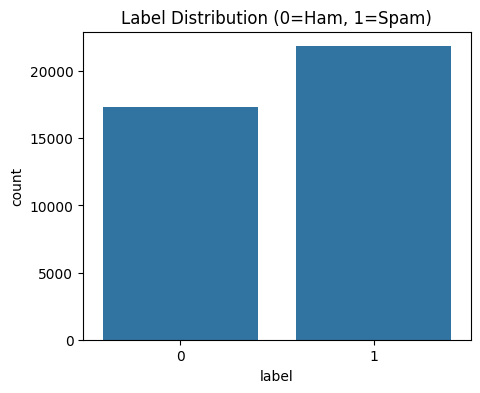


===== Average Text Length =====
count    39154.000000
mean       208.082776
std        480.180709
min          2.000000
25%         40.000000
50%         94.000000
75%        254.000000
max      19873.000000
Name: text_length, dtype: float64


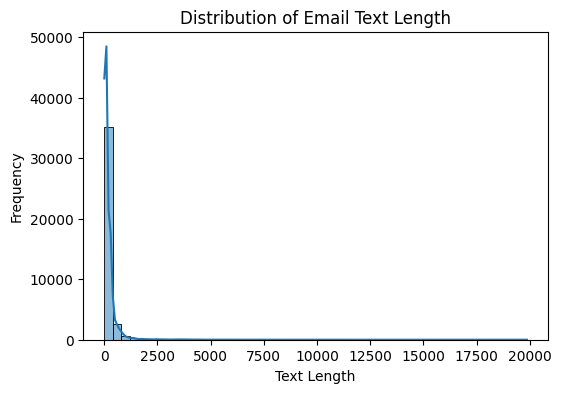

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("===== Dataset Info =====")
print(df.info())
print("\n===== Missing Values =====")
print(df.isnull().sum())

# Distribution of labels
print("\n===== Label Distribution =====")
print(df['label'].value_counts())

plt.figure(figsize=(5,4))
sns.countplot(x='label', data=df)
plt.title("Label Distribution (0=Ham, 1=Spam)")
plt.show()

# Text analysis
df["text_length"] = df["email_text"].apply(lambda x: len(str(x).split())) ## word count
print("\n===== Average Text Length =====")
print(df["text_length"].describe())

plt.figure(figsize=(6,4))
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribution of Email Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

## Data cleaning

In [6]:
import re

def clean_text_for_bert(text):
    text = re.sub(r"\s+", " ", str(text)).strip()
    return text

print("\n===== Cleaning Text... =====")
df["clean_text"] = df["email_text"].apply(clean_text_for_bert)
print("Clean Text Done")


===== Cleaning Text... =====
Clean Text Done


In [7]:
df

,email_text,label,urls,text_length,clean_text
0,"Never agree to be a loser Buck up, your troubl...",1,1,52,"Never agree to be a loser Buck up, your troubl..."
1,Befriend Jenna Jameson \nUpgrade your sex and ...,1,1,12,Befriend Jenna Jameson Upgrade your sex and pl...
2,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,1,1,306,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...
3,Re: svn commit: r619753 - in /spamassassin/tru...,0,1,2670,Re: svn commit: r619753 - in /spamassassin/tru...
4,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...,1,1,3,SpecialPricesPharmMoreinfo WelcomeFastShipping...
...,...,...,...,...,...
39149,CNN Alerts: My Custom Alert \n\nCNN Alerts: My...,1,0,96,CNN Alerts: My Custom Alert CNN Alerts: My Cus...
39150,CNN Alerts: My Custom Alert \n\nCNN Alerts: My...,1,0,99,CNN Alerts: My Custom Alert CNN Alerts: My Cus...
39151,Slideshow viewer Hello there ! \nGreat work on...,0,0,56,Slideshow viewer Hello there ! Great work on t...
39152,"Note on 2-digit years \nMail from sender , com...",0,0,105,"Note on 2-digit years Mail from sender , comin..."


## Train-test-validate split

In [8]:
from sklearn.model_selection import train_test_split

X = df["clean_text"]
y = df["label"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train size: 31323
Validation size: 3915
Test size: 3916


## Fraud email detection: using DistilBERT

In [8]:
!pip install transformers datasets accelerate -q

In [9]:
class SpamFeatureExtractor:
    """Detection of common spam characteristics"""

    @staticmethod
    def extract_features(text):
        if pd.isna(text) or not isinstance(text, str):
            text = ""

        features = {}

        # 1. CAPITAL LETTERS
        features['uppercase_ratio'] = sum(1 for c in text if c.isupper()) / (len(text) + 1)
        features['has_all_caps_words'] = int(bool(re.search(r'\b[A-Z]{3,}\b', text)))
        features['consecutive_caps'] = max([len(m.group()) for m in re.finditer(r'[A-Z]+', text)] or [0])

        # 2. URL
        features['num_urls'] = len(re.findall(r'http[s]?://\S+', text))
        features['has_url'] = int(features['num_urls'] > 0)
        features['has_suspicious_domain'] = int(bool(re.search(
            r'\.(tk|ml|ga|cf|xyz|top|click|loan|win|gq)', text, re.IGNORECASE
        )))

        # 3. Special characteristics
        features['exclamation_count'] = text.count('!')
        features['question_count'] = text.count('?')
        features['dollar_count'] = text.count('$')
        features['percent_count'] = text.count('%')
        features['special_char_ratio'] = sum(1 for c in text if not c.isalnum() and not c.isspace()) / (len(text) + 1)

        # 4. Contains numbers
        features['digit_ratio'] = sum(1 for c in text if c.isdigit()) / (len(text) + 1)
        features['has_phone_number'] = int(bool(re.search(r'\d{3}[-.]?\d{3}[-.]?\d{4}', text)))
        features['has_money_amount'] = int(bool(re.search(r'\$\d+|\d+\s?(dollars|euros|usd)', text, re.IGNORECASE)))

        # 5. Keywords
        spam_keywords = [
            'free', 'win', 'winner', 'cash', 'prize', 'bonus', 'click here',
            'buy now', 'order now', 'limited time', 'act now', 'urgent',
            'congratulations', 'selected', 'claim', 'guarantee', 'risk free',
            'viagra', 'cialis', 'pharmacy', 'weight loss', 'lose weight',
            'make money', 'work from home', 'earn', 'income', 'mlm'
        ]
        text_lower = text.lower()
        features['spam_keyword_count'] = sum(1 for kw in spam_keywords if kw in text_lower)
        features['has_spam_keywords'] = int(features['spam_keyword_count'] > 0)

        # 6. Text clues
        features['text_length'] = len(text)
        features['word_count'] = len(text.split())
        features['avg_word_length'] = sum(len(w) for w in text.split()) / (len(text.split()) + 1)
        features['line_break_ratio'] = text.count('\n') / (len(text) + 1)

        # 7. Contains HTML
        features['has_html'] = int(bool(re.search(r'<[^>]+>', text)))
        features['html_tag_count'] = len(re.findall(r'<[^>]+>', text))
        features['has_repetition'] = int(bool(re.search(r'(.{10,})\1', text)))

        return features

def preprocess_text_with_features(text, urls_count=0):
    if pd.isna(text) or not isinstance(text, str):
        text = ""

    features = SpamFeatureExtractor.extract_features(text)

    # append features before text
    # grid search?
    feature_tags = []
    if features['uppercase_ratio'] > 0.3:
        feature_tags.append("[CAPS]")
    if features['has_url'] or urls_count > 0:
        feature_tags.append(f"[URL:{urls_count}]")
    if features['spam_keyword_count'] > 2:
        feature_tags.append("[SPAM_WORDS]")
    if features['has_money_amount']:
        feature_tags.append("[MONEY]")
    if features['exclamation_count'] > 3:
        feature_tags.append("[EXCITED]")

    enhanced_text = " ".join(feature_tags) + " " + text if feature_tags else text

    return enhanced_text, features

## Main training

In [16]:
# import re
# import torch
# import pandas as pd
# from torch.utils.data import Dataset
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import (
#     accuracy_score,
#     precision_recall_fscore_support,
#     roc_auc_score
# )
# from transformers import (
#     AutoTokenizer,
#     AutoModelForSequenceClassification,
#     Trainer,
#     TrainingArguments
# )

# class SpamDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_length=256):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = str(self.texts[idx])
#         label = self.labels[idx]

#         encoding = self.tokenizer(
#             text,
#             max_length=self.max_length,
#             padding='max_length',
#             truncation=True,
#             return_tensors='pt'
#         )

#         return {
#             'input_ids': encoding['input_ids'].flatten(),
#             'attention_mask': encoding['attention_mask'].flatten(),
#             'labels': torch.tensor(label, dtype=torch.long)
#         }

# # Evaluation metrics
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)

#     precision, recall, f1, _ = precision_recall_fscore_support(
#         labels, preds, average='binary'
#     )
#     acc = accuracy_score(labels, preds)

#     # AUC
#     probs = torch.softmax(torch.tensor(pred.predictions), dim=-1)[:, 1].numpy()
#     auc = roc_auc_score(labels, probs)

#     return {
#         'accuracy': acc,
#         'f1': f1,
#         'precision': precision,
#         'recall': recall,
#         'auc': auc
#     }

# def train_spam_detector(df):

#     print("Step 1: data prep...")
#     df['text'] = df['clean_text'] if 'clean_text' in df.columns else df['email_text']

#     from tqdm import tqdm
#     tqdm.pandas()

#     results = df['text'].progress_apply(
#         lambda x: preprocess_text_with_features(x)
#     )
#     df['enhanced_text'] = [r[0] for r in results]
#     all_features = [r[1] for r in results]

#     # save features
#     features_df = pd.DataFrame(all_features)
#     print("\nFeatures（spam vs ham）:")
#     print(features_df.groupby(df['label']).mean())

#     print("\nStep 2: Dataset split...")
#     X_train, X_val, y_train, y_val = train_test_split(
#         df['enhanced_text'].values,
#         df['label'].values,
#         test_size=0.2,
#         random_state=42,
#         stratify=df['label']
#     )

#     print(f"Train: {len(X_train)}, Val: {len(X_val)}")
#     print(f"Spam_ratio - Train: {y_train.mean():.2%}, Val: {y_val.mean():.2%}")

#     print("\nStep 3: Loading model and tokenizer...")
#     tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#     model = AutoModelForSequenceClassification.from_pretrained(
#         MODEL_NAME,
#         num_labels=2,
#         problem_type="single_label_classification"
#     )

#     train_dataset = SpamDataset(X_train, y_train, tokenizer, MAX_LENGTH)
#     val_dataset = SpamDataset(X_val, y_val, tokenizer, MAX_LENGTH)

#     print("\nStep 4: Training params...")
#     training_args = TrainingArguments(
#         output_dir='./spam_detector_results',
#         num_train_epochs=EPOCHS,
#         per_device_train_batch_size=BATCH_SIZE,
#         per_device_eval_batch_size=BATCH_SIZE,
#         learning_rate=LEARNING_RATE,
#         weight_decay=0.01,
#         warmup_steps=500,
#         logging_dir='./logs',
#         logging_steps=100,
#         eval_strategy="epoch",
#         save_strategy="epoch",
#         load_best_model_at_end=True,
#         metric_for_best_model="f1",
#         push_to_hub=False,
#         fp16=torch.cuda.is_available(),
#         report_to="none"
#     )

#     # spam_ratio = y_train.mean()
#     # if spam_ratio < 0.3 or spam_ratio > 0.7:
#     #     print(f"\n⚠️ imbalanced class weights)")

#     #     # from sklearn.utils.class_weight import compute_class_weight
#     #     # class_weights = compute_class_weight('balanced', classes=[0,1], y=y_train)

#     print("\nStep 5: Training starts...")
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=val_dataset,
#         compute_metrics=compute_metrics
#     )

#     trainer.train()

#     print("\nStep 6: Evaluating...")
#     final_metrics = trainer.evaluate()
#     print("\nFinal metrics:")
#     for key, value in final_metrics.items():
#         if isinstance(value, float):
#             print(f"{key}: {value:.4f}")

#     print("\nStep 7: Saving model...")
#     model.save_pretrained('./spam_detector_final')
#     tokenizer.save_pretrained('./spam_detector_final')
#     print("✓ Model saved to ./spam_detector_final")

#     return model, tokenizer, final_metrics

In [17]:
model, tokenizer, metrics = train_spam_detector(df)

Step 1: data prep...


100%|██████████| 39154/39154 [25:12<00:00, 25.89it/s]



Features（spam vs ham）:
       uppercase_ratio  has_all_caps_words  consecutive_caps  num_urls  \
label                                                                    
0             0.054176            0.774434          5.234924  2.783156   
1             0.073174            0.381101          3.498214  3.789992   

        has_url  has_suspicious_domain  exclamation_count  question_count  \
label                                                                       
0      0.654748               0.050485           1.111483        2.551409   
1      0.681668               0.058008           0.908754        1.995147   

       dollar_count  percent_count  ...  has_money_amount  spam_keyword_count  \
label                               ...                                         
0          1.222043       0.852877  ...          0.068045            0.786449   
1          0.098617       0.102600  ...          0.032231            0.466578   

       has_spam_keywords  text_length  word_c

NameError: name 'MODEL_NAME' is not defined

In [10]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from scipy.sparse import hstack, csr_matrix

y = df['label'].values
texts = df['clean_text'].values
feature_cols = [c for c in df.columns if c not in ['email_text', 'clean_text', 'label']]

# --------------------------
# Group features
# --------------------------
groups = {
    "url_html": [
        "num_urls", "has_url", "has_suspicious_domain",
        "has_html", "html_tag_count"
    ],
    "suspicious_words": [
        "spam_keyword_count", "has_spam_keywords",
        "has_money_amount", "dollar_count", "percent_count"
    ],
    "suspicious_sentiment": [
        "uppercase_ratio", "has_all_caps_words", "consecutive_caps",
        "exclamation_count", "question_count"
    ],
    "content_structure": [
        "text_length", "word_count", "avg_word_length",
        "line_break_ratio", "has_repetition"
    ],
    "numeric_misc": [
        "special_char_ratio", "digit_ratio", "has_phone_number"
    ]
}

# --------------------------
# TF-IDF vectorization
# --------------------------
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_tfidf = tfidf.fit_transform(texts)

# --------------------------
# Evaluation matrix
# --------------------------
def eval_model(model, Xv, yv):
    preds = model.predict(Xv)
    return {
        'accuracy': accuracy_score(yv, preds),
        'precision': precision_score(yv, preds),
        'recall': recall_score(yv, preds),
        'f1': f1_score(yv, preds)
    }

def train_and_eval(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    model = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1)
    model.fit(X_train, y_train)
    return eval_model(model, X_val, y_val)

# --------------------------
# Baseline: ALL feature
# --------------------------
num_cols = [c for c in feature_cols if df[c].dtype in [np.float64, np.int64]]
X_num = df[num_cols].fillna(0).values
X_comb = hstack([X_tfidf, csr_matrix(StandardScaler().fit_transform(X_num))])

baseline_scores = train_and_eval(X_comb, y)
print("=== Baseline (All Features) ===")
print(baseline_scores)

# --------------------------
# Ablation study by group
# --------------------------
results = {"baseline": baseline_scores}
baseline_f1 = baseline_scores['f1']

for gname, gcols in groups.items():
    # remove a group
    cols_to_keep = [c for c in num_cols if c not in gcols]
    Xn = df[cols_to_keep].fillna(0).values
    X_comb = hstack([X_tfidf, csr_matrix(StandardScaler().fit_transform(Xn))])

    scores = train_and_eval(X_comb, y)
    results[gname] = scores

    delta = scores['f1'] - baseline_f1
    print(f"\n--- Removed group: {gname} ---")
    print(f"F1: {scores['f1']:.4f} (Δ {delta:+.4f})")
    print(scores)

# --------------------------
# Find most important group
# --------------------------
f1_drops = {g: results[g]['f1'] - baseline_f1 for g in groups}
sorted_groups = sorted(f1_drops.items(), key=lambda x: x[1])

print("\n=== Feature Group Importance Ranking (by F1 drop) ===")
for g, delta in sorted_groups:
    print(f"{g:25s}: ΔF1 = {delta:+.4f}")

keep_groups = [g for g, delta in sorted_groups if delta < -0.01]
print("\nRecommended groups to KEEP:", keep_groups)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=== Baseline (All Features) ===
{'accuracy': 0.9937428170093219, 'precision': 0.994053064958829, 'recall': 0.9947356374456398, 'f1': 0.9943942340693285}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- Removed group: url_html ---
F1: 0.9944 (Δ +0.0000)
{'accuracy': 0.9937428170093219, 'precision': 0.994053064958829, 'recall': 0.9947356374456398, 'f1': 0.9943942340693285}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- Removed group: suspicious_words ---
F1: 0.9944 (Δ +0.0000)
{'accuracy': 0.9937428170093219, 'precision': 0.994053064958829, 'recall': 0.9947356374456398, 'f1': 0.9943942340693285}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- Removed group: suspicious_sentiment ---
F1: 0.9944 (Δ +0.0000)
{'accuracy': 0.9937428170093219, 'precision': 0.994053064958829, 'recall': 0.9947356374456398, 'f1': 0.9943942340693285}

--- Removed group: content_structure ---
F1: 0.9967 (Δ +0.0023)
{'accuracy': 0.996296769250415, 'precision': 0.9965675057208238, 'recall': 0.9967956054016938, 'f1': 0.9966815425105847}

--- Removed group: numeric_misc ---
F1: 0.9944 (Δ +0.0000)
{'accuracy': 0.9937428170093219, 'precision': 0.994053064958829, 'recall': 0.9947356374456398, 'f1': 0.9943942340693285}

=== Feature Group Importance Ranking (by F1 drop) ===
url_html                 : ΔF1 = +0.0000
suspicious_words         : ΔF1 = +0.0000
suspicious_sentiment     : ΔF1 = +0.0000
numeric_misc             : ΔF1 = +0.0000
content_structure        : ΔF1 = +0.0023

Recommended groups to KEEP: []


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Data leakage detection

In [16]:
# ==========================================================
# Data Quality & Leakage Diagnosis for Spam Detection Features
# ==========================================================
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

print("\n" + "="*70)
print("DATA QUALITY DIAGNOSTIC REPORT")
print("="*70)

# --------------------------
# 1. Text Length Distribution
# --------------------------
print("\n[1] Text Length Distribution")
print("-" * 70)

length_stats = df.groupby('label')['text_length'].describe()
print(length_stats)

ham_mean_len = df[df['label']==0]['text_length'].mean()
spam_mean_len = df[df['label']==1]['text_length'].mean()
len_ratio = ham_mean_len / spam_mean_len
print(f"\n⚠️  Ham mean length / Spam mean length = {len_ratio:.2f}x")
if len_ratio > 2.5 or len_ratio < 0.4:
    print("   Warning: Large text length difference detected — potential data leakage!")

# --------------------------
# 2. Simple Rule-Based Accuracy Test
# --------------------------
print("\n[2] Simple Rule-Based Accuracy Test")
print("-" * 70)

# Rule 1: Based only on text length
simple_rule_1 = (df['text_length'] < 1500).astype(int)
acc_1 = (simple_rule_1 == df['label']).mean()
print(f"Rule 1: 'length < 1500 = spam' → Accuracy = {acc_1:.2%}")

# --------------------------
# 2. Simple Rule-Based Accuracy Test
# --------------------------
print("\n[2] Simple Rule-Based Accuracy Test")
print("-" * 70)

# Rule 1: Based only on text length
simple_rule_1 = (df['text_length'] < 1500).astype(int)
acc_1 = (simple_rule_1 == df['label']).mean()
print(f"Rule 1: 'length < 1500 = spam' → Accuracy = {acc_1:.2%}")

# Rule 2: Based only on word count (if available)
if 'word_count' in df.columns:
    simple_rule_2 = (df['word_count'] < 200).astype(int)
    acc_2 = (simple_rule_2 == df['label']).mean()
    print(f"Rule 2: 'word_count < 200 = spam' → Accuracy = {acc_2:.2%}")
else:
    acc_2 = 0
    print("Rule 2: (skipped — 'word_count' column not found)")

# Rule 3: Combined rule
if 'word_count' in df.columns:
    simple_rule_3 = ((df['text_length'] < 1500) | (df['word_count'] < 200)).astype(int)
else:
    simple_rule_3 = (df['text_length'] < 1500).astype(int)

acc_3 = (simple_rule_3 == df['label']).mean()
print(f"Rule 3: Combined rule → Accuracy = {acc_3:.2%}")

# --------------------------
# 3. Feature-Label Correlation
# --------------------------
print("\n[3] Feature-Label Correlation (absolute value)")
print("-" * 70)

feature_df = df[num_cols].fillna(0)
correlations = feature_df.corrwith(df['label']).abs().sort_values(ascending=False)
print(correlations.head(15))

print(f"\n⚠️  If text_length or word_count correlation > 0.6, data leakage likely!")
if correlations.get('text_length', 0) > 0.6 or correlations.get('word_count', 0) > 0.6:
    print(f"   ❌ Detected leakage: text_length corr={correlations.get('text_length', 0):.3f}")
    print(f"                        word_count corr={correlations.get('word_count', 0):.3f}")

# --------------------------
# 4. Boundary Case Analysis
# --------------------------
print("\n[4] Boundary Case Analysis")
print("-" * 70)

median_len = df['text_length'].median()
short_ham = df[(df['label']==0) & (df['text_length'] < median_len)]
long_spam = df[(df['label']==1) & (df['text_length'] > median_len)]

total_ham = len(df[df['label']==0])
total_spam = len(df[df['label']==1])

print(f"Median text length: {median_len:.0f}")
print(f"Short Ham (< median): {len(short_ham)} / {total_ham} ({len(short_ham)/total_ham:.1%})")
print(f"Long Spam (> median): {len(long_spam)} / {total_spam} ({len(long_spam)/total_spam:.1%})")

if len(short_ham)/total_ham < 0.1 or len(long_spam)/total_spam < 0.1:
    print("\n⚠️  Very few boundary cases — classes may be fully separated by length!")

# --------------------------
# 5. Single-Feature Classifier Test
# --------------------------
print("\n[5] Single-Feature Classifier Performance")
print("-" * 70)

single_feature_scores = {}
top_features_to_test = ['text_length', 'word_count', 'num_urls',
                        'spam_keyword_count', 'uppercase_ratio']

y = df['label']
for feat in top_features_to_test:
    if feat in df.columns:
        X_single = df[[feat]].fillna(0).values.reshape(-1, 1)
        X_train, X_val, y_train, y_val = train_test_split(
            X_single, y, test_size=0.2, stratify=y, random_state=42
        )
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds)
        single_feature_scores[feat] = f1
        print(f"{feat:25s}: F1 = {f1:.4f}")

print(f"\n⚠️  If a single feature achieves F1 > 0.85, it is too strong (possible leakage)!")
for feat, score in single_feature_scores.items():
    if score > 0.85:
        print(f"   ❌ {feat} alone achieves F1={score:.4f} → possible leakage feature!")

# --------------------------
# 6. Retraining after Removing Leakage Features
# --------------------------
print("\n[6] Re-evaluate after Removing Suspected Leakage Features")
print("-" * 70)

# Helper: define quick evaluation
def train_and_eval(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return {
        'accuracy': (preds == y_val).mean(),
        'precision': np.mean(preds[y_val==1]) if np.sum(preds)==0 else np.nan,
        'recall': np.mean(y_val[preds==1]) if np.sum(preds)==0 else np.nan,
        'f1': f1_score(y_val, preds)
    }

# Identify suspected leakage features
leakage_features = [feat for feat, score in single_feature_scores.items() if score > 0.85]
leakage_features.extend(['text_length', 'word_count'])  # forcibly remove
leakage_features = list(set(leakage_features))

print(f"Removed features: {leakage_features}")

# Clean feature matrix
num_cols_clean = [c for c in num_cols if c not in leakage_features]
X_num_clean = df[num_cols_clean].fillna(0).values
X_comb_clean = hstack([X_tfidf, csr_matrix(StandardScaler().fit_transform(X_num_clean))])

# Baseline
baseline_scores = train_and_eval(hstack([X_tfidf, csr_matrix(StandardScaler().fit_transform(df[num_cols].fillna(0)))]), y)
clean_scores = train_and_eval(X_comb_clean, y)

print(f"\nBaseline (All Features): F1 = {baseline_scores['f1']:.4f}")
print(f"After Removing Leakage:  F1 = {clean_scores['f1']:.4f}")
print(f"ΔF1 = {clean_scores['f1'] - baseline_scores['f1']:.4f}")

# --------------------------
# 7. Summary & Recommendations
# --------------------------
print("\n" + "="*70)
print("DIAGNOSTIC SUMMARY & RECOMMENDATIONS")
print("="*70)

issues_found = []
if max(acc_1, acc_2, acc_3) > 0.90:
    issues_found.append("✗ Simple rules achieve >90% accuracy")
if correlations.get('text_length', 0) > 0.6:
    issues_found.append("✗ text_length correlation too high")
if len(short_ham)/total_ham < 0.1:
    issues_found.append("✗ Very few boundary ham samples")
if any(score > 0.85 for score in single_feature_scores.values()):
    issues_found.append("✗ Found overly strong single feature(s)")

if issues_found:
    print("\n⚠️  Issues detected:")
    for issue in issues_found:
        print(f"   {issue}")

    print("\n📋 Recommendations:")
    print("   1. Use model without leakage features (F1={:.4f})".format(clean_scores['f1']))
    print("   2. Test on a realistic spam dataset (e.g., Enron, SpamAssassin)")
    print("   3. Verify no artificial patterns in feature extraction")

    if clean_scores['f1'] > 0.80:
        print("\n✅ Good news: After removing leaks, model still achieves {:.2%} F1".format(clean_scores['f1']))
    else:
        print("\n⚠️  Performance dropped sharply — try rebalancing or new dataset")
else:
    print("\n✅ No apparent data leakage detected.")
    print("   Model performance is trustworthy.")

print("="*70)


DATA QUALITY DIAGNOSTIC REPORT

[1] Text Length Distribution
----------------------------------------------------------------------
         count        mean         std  min    25%    50%    75%      max
label                                                                    
0      17312.0  358.224931  682.769694  2.0  109.0  195.0  363.0  19873.0
1      21842.0   89.079892  108.711389  3.0   26.0   48.0   95.0   1906.0

⚠️  Ham mean length / Spam mean length = 4.02x

[2] Simple Rule-Based Accuracy Test
----------------------------------------------------------------------
Rule 1: 'length < 1500 = spam' → Accuracy = 57.02%

[2] Simple Rule-Based Accuracy Test
----------------------------------------------------------------------
Rule 1: 'length < 1500 = spam' → Accuracy = 57.02%
Rule 2: (skipped — 'word_count' column not found)
Rule 3: Combined rule → Accuracy = 57.02%

[3] Feature-Label Correlation (absolute value)
-----------------------------------------------------------------

## check on SMS dataset

In [24]:
# ============================================
# IMPORT DEPENDENCIES
# ============================================
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# ============================================
# PREPARE DATA (Assume df already exists)
# ============================================

print("\n" + "="*70)
print("STEP 0: Extract handcrafted features for training set")
print("="*70)

df['text'] = df['clean_text']

tqdm.pandas(desc="Processing training data")

def extract_spam_features(text):
    if pd.isna(text) or not isinstance(text, str):
        text = ""
    features = {}

    # 1. Uppercase features
    features['uppercase_ratio'] = sum(1 for c in text if c.isupper()) / (len(text) + 1)
    features['has_all_caps_words'] = int(bool(re.search(r'\b[A-Z]{3,}\b', text)))
    features['consecutive_caps'] = max([len(m.group()) for m in re.finditer(r'[A-Z]+', text)] or [0])

    # 2. URL features
    features['num_urls'] = len(re.findall(r'http[s]?://\S+', text))
    features['has_url'] = int(features['num_urls'] > 0)
    features['has_suspicious_domain'] = int(bool(re.search(
        r'\.(tk|ml|ga|cf|xyz|top|click|loan|win|gq)', text, re.IGNORECASE
    )))

    # 3. Special characters
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['dollar_count'] = text.count('$')
    features['percent_count'] = text.count('%')
    features['special_char_ratio'] = sum(1 for c in text if not c.isalnum() and not c.isspace()) / (len(text) + 1)

    # 4. Numeric features
    features['digit_ratio'] = sum(1 for c in text if c.isdigit()) / (len(text) + 1)
    features['has_phone_number'] = int(bool(re.search(r'\d{3}[-.]?\d{3}[-.]?\d{4}', text)))
    features['has_money_amount'] = int(bool(re.search(r'\$\d+|\d+\s?(dollars|euros|usd|pound)', text, re.IGNORECASE)))

    # 5. Spam keywords
    spam_keywords = [
        'free', 'win', 'winner', 'cash', 'prize', 'bonus', 'click here',
        'buy now', 'order now', 'limited time', 'act now', 'urgent',
        'congratulations', 'selected', 'claim', 'guarantee', 'risk free',
        'call now', 'text', 'reply', 'txt', 'mobile', 'tone', 'ringtone'
    ]
    text_lower = text.lower()
    features['spam_keyword_count'] = sum(1 for kw in spam_keywords if kw in text_lower)
    features['has_spam_keywords'] = int(features['spam_keyword_count'] > 0)

    # 6. Text structure
    words = text.split()
    features['avg_word_length'] = sum(len(w) for w in words) / (len(words) + 1)
    features['line_break_ratio'] = text.count('\n') / (len(text) + 1)

    # 7. HTML features
    features['has_html'] = int(bool(re.search(r'<[^>]+>', text)))
    features['html_tag_count'] = len(re.findall(r'<[^>]+>', text))

    # 8. Repetition pattern
    features['has_repetition'] = int(bool(re.search(r'(.{10,})\1', text)))

    return features

# Extract and merge
features_df = df['text'].progress_apply(extract_spam_features)
features_df = pd.DataFrame(features_df.tolist())
df = pd.concat([df.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

print(f"✓ Feature extraction completed, total columns: {df.shape[1]}")

# ============================================
# STEP 1: Build optimized feature set
# ============================================
print("\n" + "="*70)
print("STEP 1: Build optimized feature set")
print("="*70)

features_to_remove = ['text_length', 'word_count']

recommended_features = [
    'num_urls', 'has_url', 'has_suspicious_domain',
    'has_html', 'html_tag_count',
    'spam_keyword_count', 'has_spam_keywords',
    'has_money_amount', 'dollar_count', 'percent_count',
    'uppercase_ratio', 'has_all_caps_words', 'consecutive_caps',
    'exclamation_count', 'question_count',
    'avg_word_length', 'line_break_ratio', 'has_repetition',
    'special_char_ratio', 'digit_ratio', 'has_phone_number'
]

final_feature_cols = [c for c in recommended_features if c in df.columns]
print(f"✓ Retained {len(final_feature_cols)} handcrafted features")
print(f"  Removed features: {features_to_remove}")

# TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_tfidf = tfidf.fit_transform(df['text'].values)

# Combine numeric + text features
X_num_final = df[final_feature_cols].fillna(0).values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num_final)
X_combined_final = hstack([X_tfidf, csr_matrix(X_num_scaled)])

y = df['label'].values
X_train, X_val, y_train, y_val = train_test_split(
    X_combined_final, y, test_size=0.2, stratify=y, random_state=42
)

final_model = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1)
final_model.fit(X_train, y_train)

def eval_model(model, Xv, yv):
    preds = model.predict(Xv)
    return {
        'accuracy': accuracy_score(yv, preds),
        'precision': precision_score(yv, preds),
        'recall': recall_score(yv, preds),
        'f1': f1_score(yv, preds)
    }

train_scores = eval_model(final_model, X_val, y_val)
print("\nValidation results on the original dataset:")
for metric, value in train_scores.items():
    print(f"  {metric:12s}: {value:.4f}")

# ============================================
# STEP 2: Load SMS Spam dataset
# ============================================
print("\n" + "="*70)
print("STEP 2: Load SMS Spam dataset")
print("="*70)

!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip -q -o smsspamcollection.zip

sms_df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label_text', 'text'])
sms_df['label'] = (sms_df['label_text'] == 'spam').astype(int)

print(f"✓ SMS dataset loaded successfully")
print(f"  Total samples: {len(sms_df)}, Spam ratio: {sms_df['label'].mean():.2%}")

# ============================================
# STEP 3: Extract same handcrafted features for SMS
# ============================================
print("\n" + "="*70)
print("STEP 3: Extract features for SMS dataset")
print("="*70)

tqdm.pandas(desc="Processing SMS data")
sms_features = sms_df['text'].progress_apply(extract_spam_features)
sms_features_df = pd.DataFrame(sms_features.tolist())
for col in final_feature_cols:
    if col not in sms_features_df.columns:
        sms_features_df[col] = 0
sms_features_df = sms_features_df[final_feature_cols]

# ============================================
# STEP 4: Apply TF-IDF transformation
# ============================================
print("\n" + "="*70)
print("STEP 4: Apply TF-IDF transformation")
print("="*70)
X_sms_tfidf = tfidf.transform(sms_df['text'].values)
X_sms_num = scaler.transform(sms_features_df.values)
X_sms_combined = hstack([X_sms_tfidf, csr_matrix(X_sms_num)])

# ============================================
# STEP 5: Evaluate on SMS dataset
# ============================================
print("\n" + "="*70)
print("STEP 5: Evaluation on SMS dataset")
print("="*70)

y_sms = sms_df['label'].values
y_sms_pred = final_model.predict(X_sms_combined)
y_sms_proba = final_model.predict_proba(X_sms_combined)[:, 1]

sms_scores = {
    'accuracy': accuracy_score(y_sms, y_sms_pred),
    'precision': precision_score(y_sms, y_sms_pred),
    'recall': recall_score(y_sms, y_sms_pred),
    'f1': f1_score(y_sms, y_sms_pred)
}

print("\n📊 Performance Comparison:")
print("-" * 70)
print(f"{'Metric':<15} {'Original Dataset':<20} {'SMS Dataset':<20} {'Difference':<15}")
print("-" * 70)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    original = train_scores[metric]
    sms_val = sms_scores[metric]
    diff = sms_val - original
    print(f"{metric:<15} {original:.4f}{'':<10} {sms_val:.4f}{'':<10} {diff:+.4f}")

# Confusion matrix
cm = confusion_matrix(y_sms, y_sms_pred)
print("\n📈 Confusion Matrix (SMS dataset):")
print("-" * 70)
print(f"                    Predicted Ham    Predicted Spam")
print(f"Actual Ham (n={cm[0].sum():<4})      {cm[0,0]:<10} {cm[0,1]:<10}")
print(f"Actual Spam (n={cm[1].sum():<4})     {cm[1,0]:<10} {cm[1,1]:<10}")

# ============================================
# STEP 6: Error analysis
# ============================================
errors = sms_df.copy()
errors['predicted'] = y_sms_pred
errors['probability'] = y_sms_proba
errors['error'] = (y_sms != y_sms_pred)
fp = errors[(errors['label']==0) & (errors['predicted']==1)]
fn = errors[(errors['label']==1) & (errors['predicted']==0)]

print(f"\nFalse Positives: {len(fp)}")
print(f"False Negatives: {len(fn)}")

# ============================================
# STEP 7: Summary and conclusion
# ============================================
print("\n" + "="*70)
print("STEP 7: Summary & Conclusion")
print("="*70)
if sms_scores['f1'] > 0.9:
    print(f"✅ Model generalizes well, F1={sms_scores['f1']:.2%}")
elif sms_scores['f1'] > 0.8:
    print(f"✓ Model performs acceptably, F1={sms_scores['f1']:.2%}")
else:
    print(f"⚠️ Model generalization is weak, F1={sms_scores['f1']:.2%}")



STEP 0: Extract handcrafted features for training set


Processing training data: 100%|██████████| 39154/39154 [26:30<00:00, 24.62it/s]


✓ Feature extraction completed, total columns: 27

STEP 1: Build optimized feature set
✓ Retained 21 handcrafted features
  Removed features: ['text_length', 'word_count']


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Validation results on the original dataset:
  accuracy    : 0.9796
  precision   : 0.9799
  recall      : 0.9835
  f1          : 0.9817

STEP 2: Load SMS Spam dataset
✓ SMS dataset loaded successfully
  Total samples: 5572, Spam ratio: 13.41%

STEP 3: Extract features for SMS dataset


Processing SMS data: 100%|██████████| 5572/5572 [00:00<00:00, 9867.05it/s]



STEP 4: Apply TF-IDF transformation

STEP 5: Evaluation on SMS dataset

📊 Performance Comparison:
----------------------------------------------------------------------
Metric          Original Dataset     SMS Dataset          Difference     
----------------------------------------------------------------------
accuracy        0.9796           0.1197           -0.8599
precision       0.9799           0.0328           -0.9471
recall          0.9835           0.1954           -0.7881
f1              0.9817           0.0562           -0.9255

📈 Confusion Matrix (SMS dataset):
----------------------------------------------------------------------
                    Predicted Ham    Predicted Spam
Actual Ham (n=4825)      521        4304      
Actual Spam (n=747 )     601        146       

False Positives: 4304
False Negatives: 601

STEP 7: Summary & Conclusion
⚠️ Model generalization is weak, F1=5.62%


In [25]:
sms_df

,label_text,text,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will ü b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0
